In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
import numpy as np

from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
class GaussianSquared(BaseSimulator):
    def __init__(self, model_noise, alpha, seed=None):
        super().__init__(dim_param=1, seed=seed)
        
        self.model_noise = model_noise
        self.alpha = alpha
        
    def gen_single(self, params):
        return { 'data' : self.model_noise * self.rng.normal() + (params[0] ** 2) }

In [36]:
seed = 678

model_noise = 0.25
alpha = 1             # Slope
# prior_var = 9

true_params = np.array([2])
obs_stats = alpha * (true_params ** 2)

n_train = 50000
n_rounds = 1

In [37]:
m = GaussianSquared(model_noise=model_noise, alpha=alpha, seed=seed)
#p = dd.Gaussian(m = [0], S = [[prior_var]], seed=seed)
p = dd.Uniform(-2 * true_params, 2 * true_params, seed=seed)
s = ds.Identity(1)
g = dg.Default(model=m, prior=p, summary=s)

In [38]:
res = infer.SNPE(g, obs=[obs_stats], n_hiddens=[10], n_components=2, seed=seed, verbose=True)

po0 = res.predict([obs_stats])
logs, tds, posteriors = res.run(n_train=n_train, n_rounds = n_rounds)

In [39]:
def plot_pdfs(dists):
    lims = 5 * np.sqrt(prior_var)
    xlist = np.linspace(-lims, lims, 200)
    
    fig, ax = plt.subplots(1, figsize=(12, 3))
    
    for i in range(len(dists)):
        d = dists[i]
        ylist = d.eval(xlist.reshape((-1,1)), log=False)# [ d.eval([x], log=False) for x in xlist ]
        ax.plot(xlist, ylist, label="Round {}".format(i))
        
    ax.axvline(true_params, c='k', ls='--')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.show()
    
    return fig

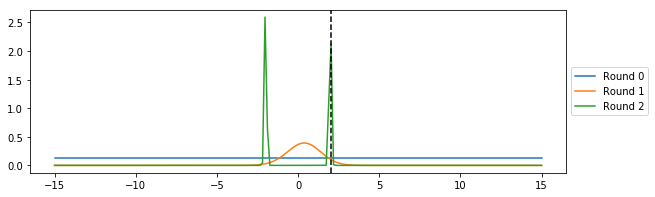

In [40]:
plot_pdfs([p, po0] + posteriors);


In [8]:
def perform_run(seed):
    m = GaussianSquared(model_noise=model_noise, alpha=alpha, seed=seed)
    p = dd.Gaussian(m = [0], S = [[prior_var]], seed=seed)
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=p, summary=s)
    
    res = infer.SNPE(g, obs=[obs_stats], n_hiddens=[10], n_components=2, seed=seed, verbose=False)

    po0 = res.predict([obs_stats])
    logs, tds, posteriors = res.run(n_train=n_train, n_rounds=n_rounds)
    
    return po0, posteriors

In [9]:
seeds = range(20)

po0s = []
posteriors = []
for seed in tqdm(seeds):
    po0, pos = perform_run(seed)
    po0s.append(po0)
    posteriors.append(pos)


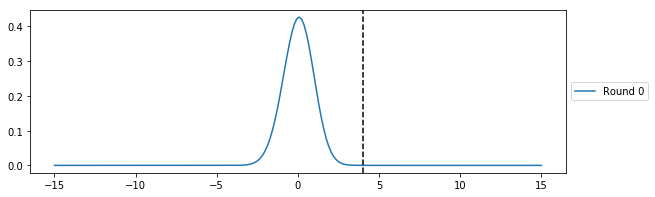

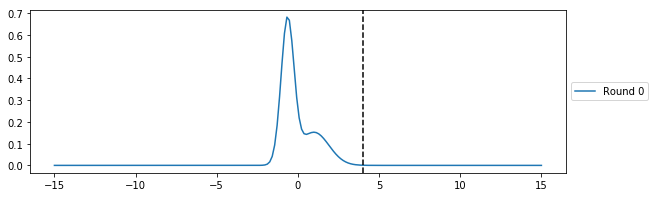

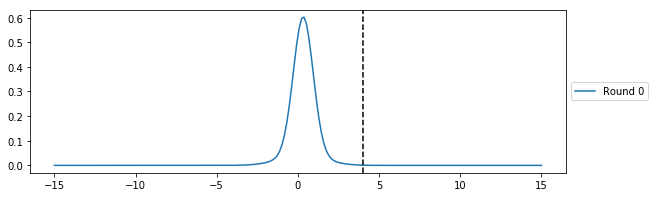

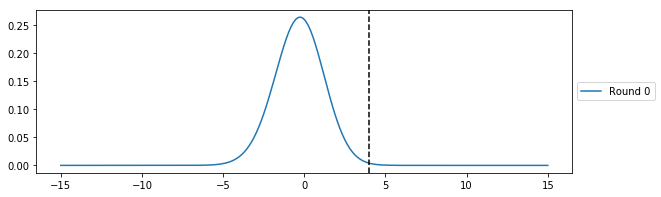

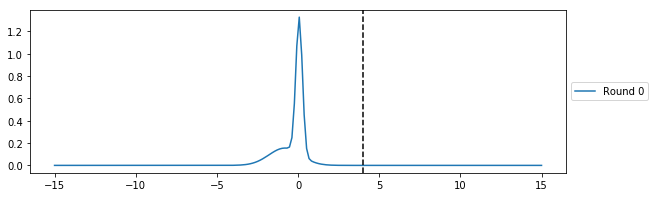

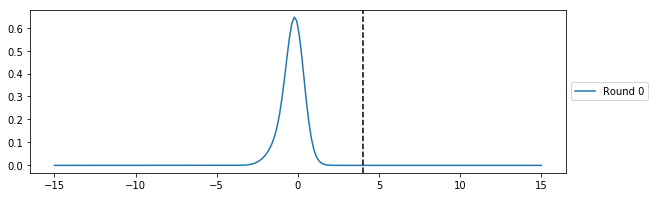

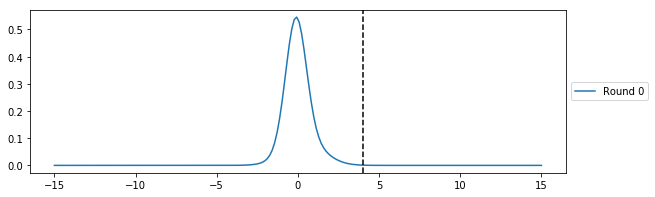

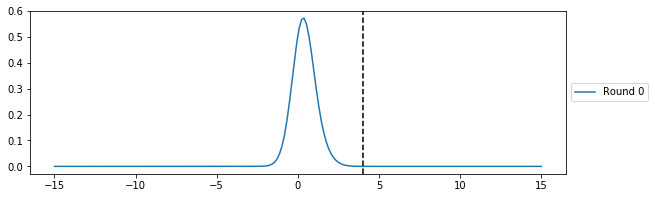

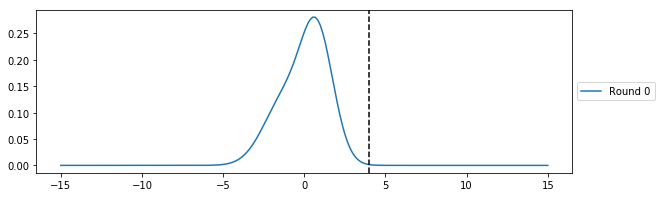

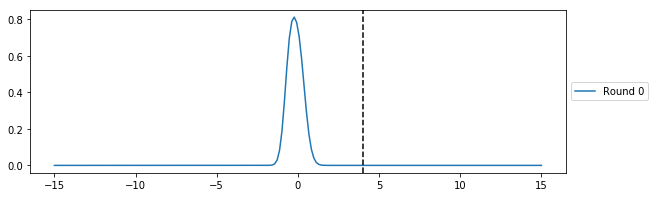

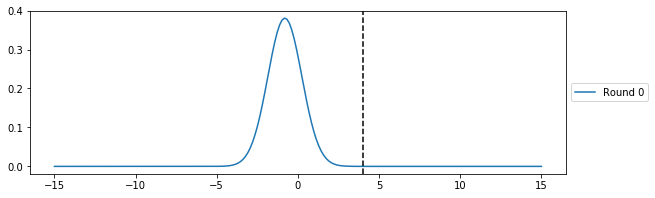

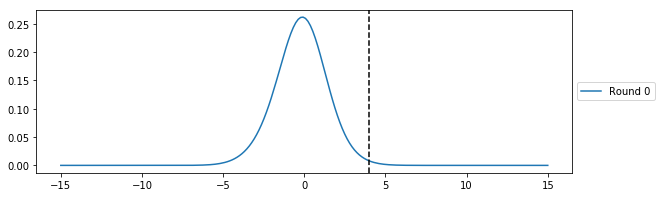

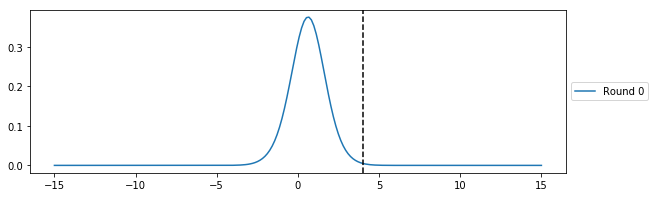

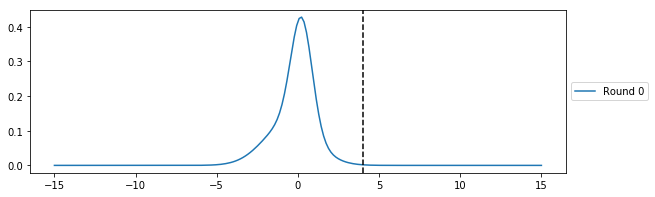

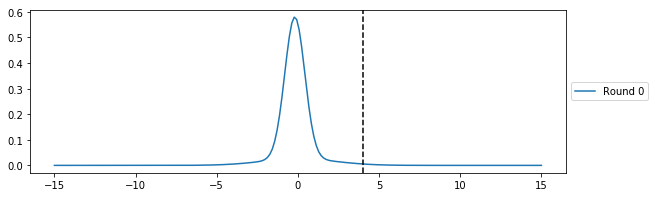

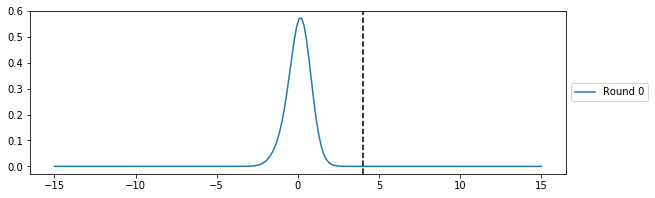

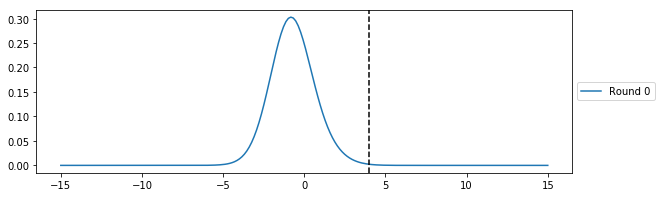

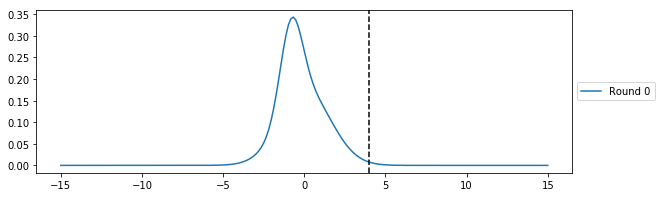

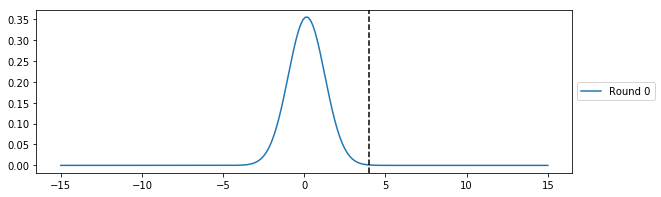

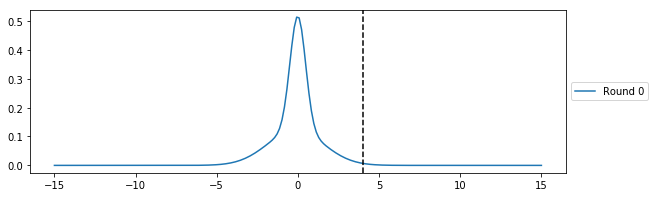

In [10]:
def is_bimodal(posterior):
    return posterior.eval([true_params], log=False) >= 0.5 and posterior.eval([-true_params], log=False) >= 0.5

bimodal = [ is_bimodal(po[-1]) for po in posteriors]

for i in range(len(po0s)):
    po0 = po0s[i]
    if bimodal[i]:
        plot_pdfs([po0])
        
print()

for i in range(len(po0s)):
    po0 = po0s[i]
    if not bimodal[i]:
        plot_pdfs([po0])
        
        